# ベイズ推定（回帰）

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## 訓練データ生成

In [2]:
x = np.random.random(20)
x = np.sort(x)
y = np.sin(2 * np.pi * x) + np.random.normal(scale=0.25, size=x.shape)
x_train = x
y_train = y

In [3]:
# 真値
xx = np.linspace(0, 1, 100)
y_true = np.sin(2 * np.pi * xx)

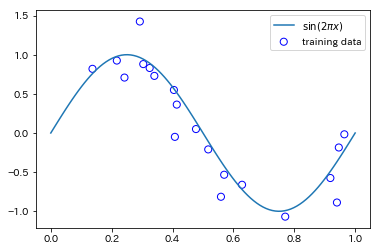

In [4]:
plt.scatter(x_train, y_train,facecolor="none", edgecolor="b", s=50,  label="training data")
plt.plot(xx, y_true, label="$\sin(2\pi x)$")
plt.legend()

## 最大事後確率推定（MAP推定）

### 学習

パラメータの推定量として、事後分布が最大となるパラメータを採用する手法である。

つまり、データを$X$、パラメータ$\boldsymbol{\theta}$に対する尤度関数を$p(X | \boldsymbol{\theta})$、$\boldsymbol{\theta}$の事前分布を$p(\boldsymbol{\theta})$とすると、

事後確率は$p(\boldsymbol{\theta} | X) = \frac{p(X | \boldsymbol{\theta}) p(\boldsymbol{\theta})}{p(X)}$であり、推定量は$\boldsymbol{\theta}_{MAP} = \text{argmax}_{\boldsymbol{\theta}} p(\boldsymbol{\theta} | X)$である。

訓練データを$X = [x_{1}, x_{2}, ..., x_{n}]^{\mathrm{T}}, \boldsymbol{y} = [y_{1}, y_{2}, ..., y_{n}]^{\mathrm{T}}$とする。

入力に対する出力の分布として$p(y |x, \boldsymbol{w}; \beta) = \mathcal{N} (y | f(\boldsymbol{w}, x), \beta^{-1})$のようなモデルを考える。

パラメータ$\boldsymbol{w}$に対する尤度関数、$\boldsymbol{w}$の事前分布を以下のように仮定する。

$p(\boldsymbol{y} |X, \boldsymbol{w}; \beta) = \prod_{i=1}^{n} \mathcal{N} (y_{i} | \boldsymbol{w}^{\mathrm{T}}\boldsymbol{\phi}(x_{i}), \beta^{-1})$

$p(\boldsymbol{w}; \alpha) = \mathcal{N} (\boldsymbol{w} | \boldsymbol{0}, \alpha^{-1}I)$

ただし、$\boldsymbol{w}=[w_{0}, w_{1}, ..., w_{d}]^{\mathrm{T}}, \boldsymbol{\phi}(x) = [1, x, x^{2}, ..., x^{d}]^{\mathrm{T}}$であり、$\alpha, \beta$はハイパーパラメータである。

$\alpha$は事前分布の精度（分散の逆数）を表し, $\beta$はノイズの精度を表す。

このとき（ガウス分布の積なので）事後分布もガウス分布になり、計算すると以下のように書ける。

$p(\boldsymbol{w} | X, \boldsymbol{y}) = \mathcal{N} (\boldsymbol{w} | \boldsymbol{m}, S)$

$\boldsymbol{m} = \beta S \Phi^{\mathrm{T}} \boldsymbol{y}$

$S = (\alpha I + \beta \Phi^{\mathrm{T}} \Phi)^{-1}$

ただし、$\Phi = [\boldsymbol{\phi}(x_{1}), \boldsymbol{\phi}(x_{2}),.., \boldsymbol{\phi}(x_{n})]^{\mathrm{T}}$である。

この結果よりMAP推定量は$\boldsymbol{w}_{MAP} = \boldsymbol{m}$である。

In [5]:
def polynomial_features(x, degree=3):
    """多項式特徴ベクトルに変換
         X = [[1, x1, x1^2, x1^3],
                 [1, x2, x2^2, x2^3],
                   ...                             
                 [1, xn, xn^2, xn^3]]"""
    X = np.ones((len(x), degree+1))
    X_t = X.T
    for i in range(1, degree+1):
        X_t[i] = X_t[i-1] * x
    return X_t.T

In [6]:
alpha = 0.01
beta = 10
d = 5

Phi = polynomial_features(x_train, d)
S = np.linalg.inv( alpha * np.identity(d+1) + beta * np.dot(Phi.T, Phi) )
m = beta * np.dot(S, Phi.T).dot(y_train)
w_MAP = m

### 予測

入力を多項式特徴ベクトル$\boldsymbol{\phi(x)}$に変換し、$y = \boldsymbol{w}_{MAP} \boldsymbol{\phi(x)}\  (\boldsymbol{y}(x) = \Phi \boldsymbol{w}_{MAP})$で予測する。

In [7]:
Phi_test = polynomial_features(xx, d)
y_pred = np.dot(Phi_test, w_MAP )

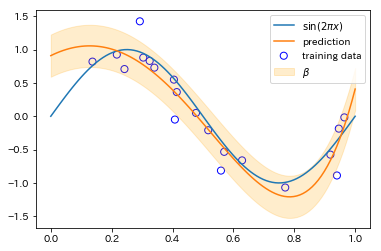

In [8]:
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(xx, y_true, label="$\sin(2\pi x)$")
plt.plot(xx, y_pred, label="prediction")
std = 1. / np.sqrt(beta)
plt.fill_between(xx, y_pred-std, y_pred+std, alpha=0.2, color='orange', label="$\\beta$")
plt.legend()
plt.show()

## 予測分布

予測の分布をパラメータの事後分布で周辺化することで求める。つまり新しい入力$x$に対する出力$y$の分布は

$p(y | x, X, \boldsymbol{y}; \alpha, \beta) = \int p(y |x, \boldsymbol{w}; \beta) p(\boldsymbol{w} | X, \boldsymbol{y}; \alpha, \beta) d \boldsymbol{w}$

となる。これを計算すると次のようになる。

$p(y | x, X, \boldsymbol{y}; \alpha, \beta) = \mathcal{N} (y | \boldsymbol{m}^{\mathrm{T}} \phi(x), \sigma^{2}(x))$

$\sigma^{2}(x) = \beta^{-1} + \boldsymbol{\phi}(x)^{\mathrm{T}} S \boldsymbol{\phi}(x)$

In [9]:
var = 1. / beta + np.sum(np.dot(Phi_test, S) * Phi_test, axis=1)
sigma = np.sqrt(var)

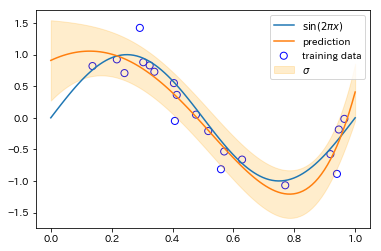

In [10]:
plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(xx, y_true, label="$\sin(2\pi x)$")
plt.plot(xx, y_pred, label="prediction")
plt.fill_between(xx, y_pred-sigma, y_pred+sigma, alpha=0.2, color='orange', label="$\sigma$")
plt.legend()
plt.show()